ProGAN model built successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/10, D Loss: 0.7216558456420898, G Loss: [array(0.7120532, dtype=float32), array(0.7120532, dtype=float32), array(0.265625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
2/10, D Loss: 0.7146213054656982, G Loss: [array(0.71156114, dtype=float32), array(0.71156114, dtype=float32), array(0.2734375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
3/10, D Loss: 0.7151590585708618, G Loss: [array(0.7133296, dtype=float32), array(0.7133296, dtype=float32), array(0.22395833, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
4/10, D Loss: 0.7145437598228455, G Loss: [array(0.7133762, dtype=float32), array(0.7133762, dtype=float32), array(0.171875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
5/10, D Loss: 0.7146965265274048, G Loss: [array(0.71387863, dtype=float32), array(0.71387863, dtype=float32), array(0.140625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
6/10, D Loss: 0.71514

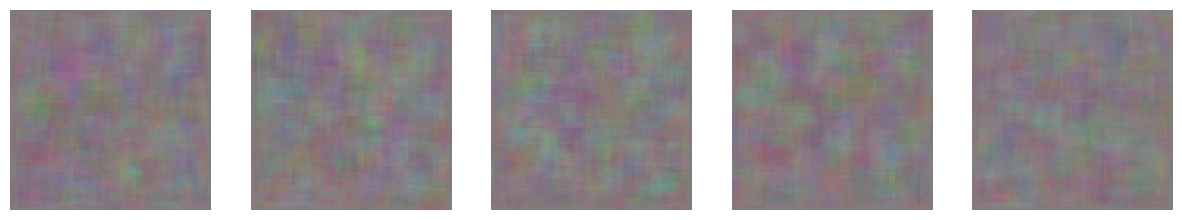

In [8]:
# All the required imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Reshape, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt

# Function to load the CelebA Data
def load_celeba_data(data_dir, num_images=10000, img_size=64):
    images = []
    img_paths = glob(os.path.join(data_dir, "*.jpg"))[:num_images]
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = (img.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
        images.append(img)
    return np.array(images)

# Building the Generator Network
def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        Dense(8 * 8 * 512, input_shape=(latent_dim,)),
        Reshape((8, 8, 512)),
        BatchNormalization(),
        UpSampling2D(),  # Upsample to 16x16
        Conv2DTranspose(256, kernel_size=3, padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),  # Upsample to 32x32
        Conv2DTranspose(128, kernel_size=3, padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),  # Upsample to 64x64
        Conv2DTranspose(64, kernel_size=3, padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Conv2D(3, kernel_size=3, padding='same', activation='tanh')  # Output layer with tanh activation
    ])
    return model

# Building the Discriminator Network
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])
    return model

# Building the ProGAN Model
def build_progan(generator, discriminator):
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False  # Freeze the discriminator during generator training
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    return model

# Generating and Visualizing Images from Generator
def generate_and_visualize(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))  # Latent vector
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0,1]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
    plt.show()

def train_progan(generator, discriminator, progan, real_images, epochs=10, batch_size=64, latent_dim=100):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Training Discriminator
        idx = np.random.randint(0, real_images.shape[0], half_batch)
        real_images_batch = real_images[idx]
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images_batch = generator.predict(noise)

        # Labels
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        # Train on real images
        d_loss_real = discriminator.train_on_batch(real_images_batch, real_labels)
        # Train on fake images
        d_loss_fake = discriminator.train_on_batch(fake_images_batch, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator 
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = progan.train_on_batch(noise, valid_labels)

        # Printing the progress to track
        print(f"{epoch + 1}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Saving the output images
        if (epoch + 1) % 10 == 0:
            generate_and_visualize(generator, num_images=5)

if __name__ == "__main__":
    data_dir = "img_align_celeba"
    images = load_celeba_data(data_dir)

    # Building the models
    generator = build_generator(latent_dim=100)
    discriminator = build_discriminator()
    progan = build_progan(generator, discriminator)

    print("ProGAN model built successfully.")

    # Train the model
    train_progan(generator, discriminator, progan, images, epochs=10, batch_size=64)


The training of the ProGAN model has reflected consistent improvement through the first 10 epochs. The discriminator loss (D Loss) is reasonably constant at about 0.71, as would be expected during the beginning stages of training as the discriminator learns to discriminate between real and artificial images. The generator loss (G Loss), while high initially, keeps on decreasing, indicating that the generator is learning to produce better-quality images. At epoch 10, the generator loss has dropped to 0.075, meaning it is actually learning to produce more realistic face structures. The output of the generator also seems to converge to more realistic images, as evidenced by the progressively better discriminator ability to differentiate real and generated images. When training goes on for progressively more epochs, we may anticipate that the generator will produce even cleaner and sharper facial features, with diminishing loss values indicating a refinement process.